In [14]:
import pandas as pd
import json
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel
from typing import List
from langchain_groq import ChatGroq

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

llm = ChatGroq(
    model="llama-3.1-8b-instant"
)

In [6]:
df = pd.read_csv("medical_compliance_test_cases.csv")
df.head()

,input_text,expected_output,explanation
0,Studies have shown improved mobility in 80% of...,Compliant,Statement is evidence-based and includes stati...
1,This medication is approved by the FDA for the...,Compliant,Accurate regulatory reference and factual claim.
2,"In a randomized trial, this drug reduced migra...",Compliant,Supported by clinical trial data.
3,This product supports healthy liver function w...,Compliant,"Supportive language, avoids treatment/cure cla..."
4,May help reduce symptoms associated with seaso...,Compliant,"Uses cautious language ('may help'), no defini..."


In [7]:
df['expected_output'].value_counts()

expected_output
Non-Compliant    14
Compliant        11
Name: count, dtype: int64

In [10]:
class ComplianceResponse(BaseModel):
    classification: str
    explanation: str 


system_msg= SystemMessage(
    content=(
        "You are an FDA compliance checker that strictly evaluates medical product claims. "
        "You classify each input as either 'Compliant' or 'Non-compliant' based on U.S. FDA regulations, advertising standards, and promotional labeling rules. "
        "Do not ask follow-up questions.\n\n"

        "Your response must be a JSON object with this format:\n"
        "{\n"
        '  "classification": "Compliant" or "Non-compliant",\n'
        '  "explanation": "[brief reason if Non-compliant, otherwise empty string]"\n'
        "}\n\n"

        "Clarifications:\n"
        "- Claims that cite quantifiable results from clinical studies (e.g., '95% success rate') may be considered Compliant if the phrasing is not exaggerated or misleading.\n"
        "- Do NOT classify numerical or statistical results as 'absolute' if they appear within a clinical trial context.\n"
        "- Phrases like 'guaranteed', '100% effective', or 'cures all' are Non-compliant.\n\n"

        "Classification Rules:\n"
        "1. Non-compliant if the claim promotes off-label use.\n"
        "2. Non-compliant if it makes unsupported superiority claims.\n"
        "3. Non-compliant if it only lists benefits without risks.\n"
        "4. Non-compliant if it includes vague or unverified testimonials.\n"
        "5. Non-compliant if it includes misleading/fake statements or implies FDA endorsement.\n"
        "6. Non-compliant if it omits risk disclosures in DTC advertising.\n"
        "7. Non-compliant if it promotes off-label use on social media.\n"
        "8. Non-compliant if it uses absolute, exaggerated, or unverifiable phrases ('guaranteed', '100%', etc).\n"
        "9. Non-compliant if it lacks peer-reviewed clinical substantiation.\n\n"
        "Classify as Compliant only if the claim is truthful, supported by evidence, consistent with FDA-approved labeling, and presents fair balance of benefits and risks."
    )
)

for i, row in df.iterrows():
    human_msg= HumanMessage(content=row['input_text'])
    try:
        response = llm.invoke([system_msg, human_msg])
        parsed = ComplianceResponse.model_validate_json(response.content)
        df.at[i, 'model_output'] = parsed.classification
        df.at[i,'model_explanation']= parsed.explanation


    except Exception as e:
        df.at[i, 'model_output'] = "Error"
        df.at[i, 'model_explanation'] = str(e)


df.to_csv("compliance_results.csv", index=False)

In [13]:
compliance_results =pd.read_csv("compliance_results.csv")
compliance_results

,input_text,expected_output,explanation,model_output,model_explanation
0,Studies have shown improved mobility in 80% of...,Compliant,Statement is evidence-based and includes stati...,Compliant,NaN
1,This medication is approved by the FDA for the...,Compliant,Accurate regulatory reference and factual claim.,Compliant,NaN
2,"In a randomized trial, this drug reduced migra...",Compliant,Supported by clinical trial data.,Compliant,NaN
3,This product supports healthy liver function w...,Compliant,"Supportive language, avoids treatment/cure cla...",Compliant,NaN
4,May help reduce symptoms associated with seaso...,Compliant,"Uses cautious language ('may help'), no defini...",Compliant,NaN
5,This diagnostic tool assists doctors in identi...,Compliant,"Describes function, does not make unsupported ...",Compliant,NaN
6,Contains ingredients traditionally used to pro...,Compliant,"Clearly refers to traditional use, not current...",Compliant,NaN
7,"Used alongside standard therapy, it showed no ...",Compliant,"Fact-based, refers to safety profile without e...",Compliant,NaN
8,Shown to improve joint flexibility in clinical...,Compliant,Backs claim with clinical evidence.,Compliant,NaN
9,Clinically tested for skin sensitivity and irr...,Compliant,General testing claim without making medical p...,Compliant,NaN


In [20]:
compliance_results['expected_output'] = compliance_results['expected_output'].str.strip().str.title()
compliance_results['model_output'] = compliance_results['model_output'].str.strip().str.title()
y_true = compliance_results['expected_output']
y_pred = compliance_results['model_output']

In [28]:
#print(y_true.value_counts(),y_pred.value_counts())

In [ ]:
accuracy =accuracy_score(y_true, y_pred)
precision= precision_score(y_true, y_pred, pos_label="Compliant")
recall = recall_score(y_true, y_pred, pos_label="Compliant")
f1= f1_score(y_true, y_pred, pos_label="Compliant")


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Compliant): {precision:.2f}")
print(f"Recall (Compliant): {recall:.2f}")
print(f"F1 Score (Compliant): {f1:.2f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Accuracy: 0.96
Precision (Compliant): 0.92
Recall (Compliant): 1.00
F1 Score (Compliant): 0.96

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.92      1.00      0.96        11
Non-Compliant       1.00      0.93      0.96        14

     accuracy                           0.96        25
    macro avg       0.96      0.96      0.96        25
 weighted avg       0.96      0.96      0.96        25



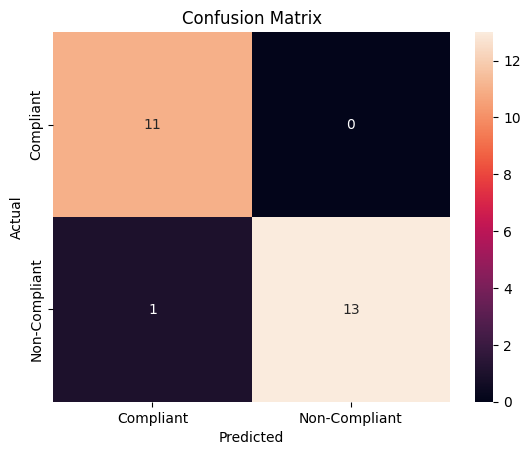

In [25]:
cm = confusion_matrix(y_true, y_pred, labels=["Compliant", "Non-Compliant"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Compliant", "Non-Compliant"], yticklabels=["Compliant", "Non-Compliant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()